In [2]:
import os
import sys
import warnings
from datetime import datetime as dt

import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from IPython.core.display import HTML
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

warnings.filterwarnings("ignore")


In [3]:
data = pd.read_pickle("../data/Airlines_tickets_data_EDA_ready.pkl")
data.head()

,origin,finaldest,return,year,quarter,airports,return_sym,stops,avgprice,passengers,...,city_D1,state_D1,hhi,route,carrier,n_carriers,inv_n_carriers,share_LCC,share_Legacy,carrier_type_dominant
0,ABE,ABI,1,2010,2,7,1.0,2,530.0,1,...,Abilene,TX,20000.0,ABE-ABI,XE,8,0.125,0.0,0.0,Mixed/Other
1,ABE,ABI,1,2010,3,7,0.0,2,822.5,2,...,Abilene,TX,7500.0,ABE-ABI,AA,8,0.125,0.0,0.5,Legacy-dominant
2,ABE,ABI,1,2010,4,7,1.0,2,389.5,2,...,Abilene,TX,20000.0,ABE-ABI,MQ,8,0.125,0.0,0.0,Mixed/Other
3,ABE,ABI,1,2011,1,7,1.0,2,381.0,1,...,Abilene,TX,20000.0,ABE-ABI,MQ,8,0.125,0.0,0.0,Mixed/Other
4,ABE,ABI,1,2011,3,7,1.0,2,1096.0,1,...,Abilene,TX,20000.0,ABE-ABI,MQ,8,0.125,0.0,0.0,Mixed/Other


In [4]:
data.columns

Index(['origin', 'finaldest', 'return', 'year', 'quarter', 'airports',
       'return_sym', 'stops', 'avgprice', 'passengers', 'itinfare',
       'sharelargest', 'share16', 'share9E', 'share9L', 'shareAA', 'shareAS',
       'shareB6', 'shareCO', 'shareCP', 'shareCS', 'shareDL', 'shareEV',
       'shareF8', 'shareF9', 'shareFL', 'shareG4', 'shareG7', 'shareHA',
       'shareL3', 'shareMQ', 'shareNK', 'shareOH', 'shareOO', 'shareOW',
       'shareQX', 'shareRP', 'shareS5', 'shareSY', 'shareU5', 'shareUA',
       'shareUS', 'shareVX', 'shareWN', 'shareXE', 'shareXJ', 'shareYV',
       'shareYX', 'shareZW', 'treated', 'smallmkt', 'code_O', 'icao_O',
       'name_O', 'latitude_O', 'longitude_O', 'elevation_O', 'url_O',
       'time_zone_O', 'city_code_O', 'country_O', 'city_O', 'state_O',
       'county_O', 'type_O', 'code_D', 'icao_D', 'name_D', 'latitude_D',
       'longitude_D', 'elevation_D', 'url_D', 'time_zone_D', 'city_code_D',
       'country_D', 'city_D', 'state_D', 'county_D', 'ty

#### 1. Relative fare

In [4]:
# Compute relative fare: price compared to average on same origin-destination & time period
data['rel_fare'] = data.groupby(['origin', 'finaldest', 'year', 'quarter'])['avgprice'].transform(lambda x: x / x.mean())

#### 2. Segment

In [5]:
data['segment'] = np.select(
    [
        (data['return']==1) & (data['stops']==0) & (data['rel_fare']>1.1),
        (data['return']==0) & (data['stops']>0)
    ],
    ['business', 'leisure'],
    default='mixed'
)

In [6]:
data['segment'].value_counts()

segment
mixed       1284882
leisure     1029309
business      30888
Name: count, dtype: int64

#### 3. Segment Boxplot

,count,mean,std,min,25%,50%,75%,max
segment,,,,,,,,
business,30888.0,254.341396,173.743691,5.0,98.801211,234.489585,381.90823,2597.6
leisure,1029309.0,331.650364,192.495391,0.0,213.920000,297.800000,414.00000,4525.0
mixed,1284882.0,517.095244,264.892712,0.0,374.000000,484.833340,616.35297,7063.0


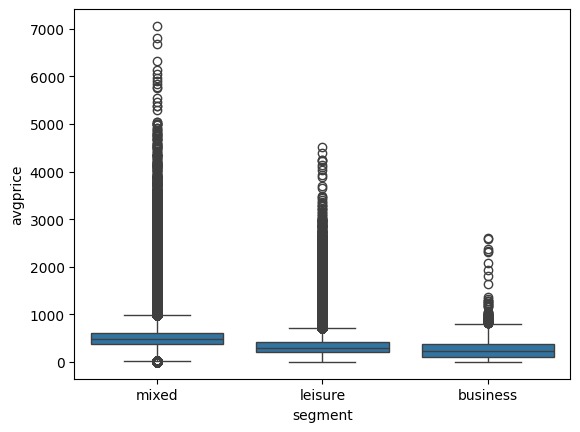

In [7]:
sns.boxplot(x='segment', y='avgprice', data=data)
data.groupby('segment')['avgprice'].describe()

#### 4. Route

In [11]:
sample = data.sample(50000, random_state=42).copy()
sample = sample[sample['avgprice'] > 0].copy()
sample['log_price'] = np.log(sample['avgprice'])
relevant_cols = ['log_price', 'segment', 'carrier', 'quarter', 'year', 'route']
sample = sample.dropna(subset=relevant_cols)
m = smf.ols(
    'log_price ~ C(segment) + C(carrier) + C(quarter) + C(year)',
    data=sample
).fit(cov_type='cluster', cov_kwds={'groups': sample['route']})
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.238
Method:                 Least Squares   F-statistic:                     232.2
Date:                Mon, 06 Oct 2025   Prob (F-statistic):               0.00
Time:                        16:24:09   Log-Likelihood:                -50483.
No. Observations:               49807   AIC:                         1.011e+05
Df Residuals:                   49759   BIC:                         1.015e+05
Df Model:                          47                                         
Covariance Type:              cluster                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 5.49

<Axes: xlabel='avgprice', ylabel='Count'>

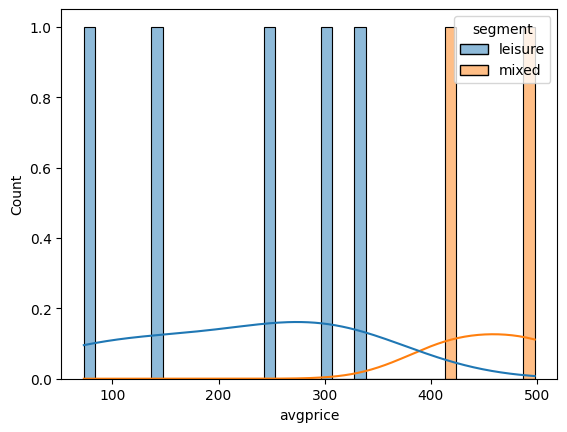

In [12]:
route_ex = sample[sample['route']=="PHX-SPS"]
sns.histplot(route_ex, x='avgprice', hue='segment', bins=40, kde=True)

In [13]:
sample[sample['route']=="PHX-SPS"].T

,1744051,1744030,1744056,1744059,1744036,1744028,1744052
origin,PHX,PHX,PHX,PHX,PHX,PHX,PHX
finaldest,SPS,SPS,SPS,SPS,SPS,SPS,SPS
return,0,0,1,1,0,0,0
year,2016,2011,2011,2011,2012,2010,2016
quarter,3,2,1,4,4,4,4
...,...,...,...,...,...,...,...
segment,leisure,leisure,mixed,mixed,leisure,leisure,leisure
route,PHX-SPS,PHX-SPS,PHX-SPS,PHX-SPS,PHX-SPS,PHX-SPS,PHX-SPS
carrier,AA,AA,AA,AA,AA,AA,AA
log_avg_price,5.695974,4.981893,6.039064,6.210265,4.290459,5.504315,5.799093


In [14]:
# Actual revenue
sample['rev_actual'] = sample['avgprice'] * sample['passengers']

# Uniform price: charge everyone the route-quarter mean
sample['avg_uniform'] = sample.groupby(['route','year','quarter'])['avgprice'].transform('mean')
sample['rev_uniform'] = sample['avg_uniform'] * sample['passengers']

rev_comparison = (sample.groupby('segment')[['rev_actual','rev_uniform']]
                    .sum().assign(rev_gain=lambda x: (x.rev_actual/x.rev_uniform-1)*100))
rev_comparison

,rev_actual,rev_uniform,rev_gain
segment,,,
business,4.206123e+07,4.186692e+07,0.464117
leisure,1.713435e+08,1.729274e+08,-0.915929
mixed,5.006035e+08,4.986636e+08,0.389028


<Axes: xlabel='cluster', ylabel='avgprice'>

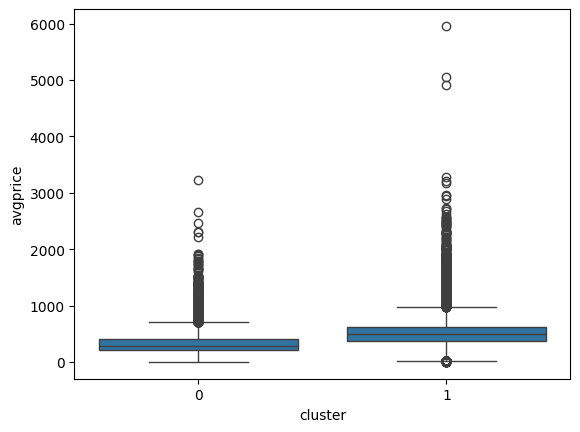

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

X = sample[['rel_fare','stops','return']].copy()
X = StandardScaler().fit_transform(X)

sample['cluster'] = KMeans(n_clusters=2, random_state=0).fit_predict(X)
sns.boxplot(x='cluster', y='avgprice', data=sample)

In [16]:
data.columns

Index(['origin', 'finaldest', 'return', 'year', 'quarter', 'airports',
       'return_sym', 'stops', 'avgprice', 'passengers', 'itinfare',
       'sharelargest', 'share16', 'share9E', 'share9L', 'shareAA', 'shareAS',
       'shareB6', 'shareCO', 'shareCP', 'shareCS', 'shareDL', 'shareEV',
       'shareF8', 'shareF9', 'shareFL', 'shareG4', 'shareG7', 'shareHA',
       'shareL3', 'shareMQ', 'shareNK', 'shareOH', 'shareOO', 'shareOW',
       'shareQX', 'shareRP', 'shareS5', 'shareSY', 'shareU5', 'shareUA',
       'shareUS', 'shareVX', 'shareWN', 'shareXE', 'shareXJ', 'shareYV',
       'shareYX', 'shareZW', 'treated', 'smallmkt', 'code_O', 'icao_O',
       'name_O', 'latitude_O', 'longitude_O', 'elevation_O', 'url_O',
       'time_zone_O', 'city_code_O', 'country_O', 'city_O', 'state_O',
       'county_O', 'type_O', 'code_D', 'icao_D', 'name_D', 'latitude_D',
       'longitude_D', 'elevation_D', 'url_D', 'time_zone_D', 'city_code_D',
       'country_D', 'city_D', 'state_D', 'county_D', 'ty

In [17]:
rich_cities = ['San Francisco', 'New York', 'Boston', 'Seattle', 'Los Angeles', 'Washington', 'Chicago']
data['rich_origin'] = data['city_O'].isin(rich_cities).astype(int)
data['rich_destination'] = data['city_D'].isin(rich_cities).astype(int)

In [18]:
data['rich_origin'].value_counts()

rich_origin
0    2326529
1      18550
Name: count, dtype: int64

In [19]:
data.groupby('rich_origin')['avgprice'].mean()

rich_origin
0    432.674551
1    377.535447
Name: avgprice, dtype: float64

In [20]:
print(data[['rich_origin','rich_destination']].corr())

                  rich_origin  rich_destination
rich_origin            1.0000           -0.0031
rich_destination      -0.0031            1.0000


In [21]:
data['avgprice'].describe()

count    2.345079e+06
mean     4.322384e+02
std      2.528049e+02
min      0.000000e+00
25%      2.686667e+02
50%      4.021892e+02
75%      5.452000e+02
max      7.063000e+03
Name: avgprice, dtype: float64

In [22]:
data['avgprice'].describe()
(data['avgprice'] <= 0).sum()
data['avgprice'].isna().sum()

np.int64(0)

In [23]:
data['rich_origin'].value_counts(dropna=False)
data['rich_destination'].value_counts(dropna=False)

rich_destination
0    2326322
1      18757
Name: count, dtype: int64

In [24]:
data.columns

Index(['origin', 'finaldest', 'return', 'year', 'quarter', 'airports',
       'return_sym', 'stops', 'avgprice', 'passengers', 'itinfare',
       'sharelargest', 'share16', 'share9E', 'share9L', 'shareAA', 'shareAS',
       'shareB6', 'shareCO', 'shareCP', 'shareCS', 'shareDL', 'shareEV',
       'shareF8', 'shareF9', 'shareFL', 'shareG4', 'shareG7', 'shareHA',
       'shareL3', 'shareMQ', 'shareNK', 'shareOH', 'shareOO', 'shareOW',
       'shareQX', 'shareRP', 'shareS5', 'shareSY', 'shareU5', 'shareUA',
       'shareUS', 'shareVX', 'shareWN', 'shareXE', 'shareXJ', 'shareYV',
       'shareYX', 'shareZW', 'treated', 'smallmkt', 'code_O', 'icao_O',
       'name_O', 'latitude_O', 'longitude_O', 'elevation_O', 'url_O',
       'time_zone_O', 'city_code_O', 'country_O', 'city_O', 'state_O',
       'county_O', 'type_O', 'code_D', 'icao_D', 'name_D', 'latitude_D',
       'longitude_D', 'elevation_D', 'url_D', 'time_zone_D', 'city_code_D',
       'country_D', 'city_D', 'state_D', 'county_D', 'ty

In [25]:
data['rich_origin'] = data['rich_origin'].fillna(0).astype(int)
data['rich_destination'] = data['rich_destination'].fillna(0).astype(int)

In [26]:
negative_log_avgprice = data[data['log_avg_price'] < 0]
print(negative_log_avgprice[['avgprice', 'log_avg_price']])

         avgprice  log_avg_price
225           0.0           -inf
237           0.0           -inf
249           0.0           -inf
1115          0.0           -inf
1293          0.0           -inf
...           ...            ...
2342224       0.0           -inf
2342371       0.0           -inf
2343607       0.0           -inf
2344318       0.0           -inf
2345060       0.0           -inf

[9796 rows x 2 columns]


In [27]:
data_no_neginf = data[~np.isneginf(data['log_avg_price'])]
m = smf.ols('log_avg_price ~ rich_origin + rich_destination', data=data_no_neginf).fit()
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:          log_avg_price   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     525.7
Date:                Mon, 06 Oct 2025   Prob (F-statistic):          5.53e-229
Time:                        16:24:33   Log-Likelihood:            -2.6656e+06
No. Observations:             2335297   AIC:                         5.331e+06
Df Residuals:                 2335294   BIC:                         5.331e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            5.8768      0.000  

### II. Regression

In this regression, I examine how airline competition and market characteristics affect ticket pricing across U.S. domestic routes.

The main goal is to test whether prices **decrease when more airlines operate on the same route** — a key assumption of **competitive markets**.

The variable `n_carriers` captures the number of airlines per route, serving as a proxy for competition intensity.

I control for flight characteristics (`stops`), carrier-specific pricing differences (C(`carrier`)), and regional income effects (`rich_origin`, `rich_destination`) to isolate the impact of competition on fares.

By analyzing these relationships, I aim to detect potential evidence of **monopoly-based price** discrimination and assess whether competition actually translates into lower consumer prices in the airline industry.

In [28]:
#create n_carriers variable
route_comp = data.groupby('route')['carrier'].nunique().reset_index(name='n_carriers')
data = data.merge(route_comp, on='route')

In [29]:
#make sure there are no -inf log_avg_price
data_no_neginf = data[~np.isneginf(data['log_avg_price'])]

In [30]:
sample = data_no_neginf.sample(frac=0.15, random_state=42)

In [31]:
m_comp = smf.ols(
    'log_avg_price ~ n_carriers + stops + C(carrier) + rich_origin + rich_destination',
    data=sample
).fit()

print(m_comp.summary())

                            OLS Regression Results                            
Dep. Variable:          log_avg_price   R-squared:                       0.186
Model:                            OLS   Adj. R-squared:                  0.186
Method:                 Least Squares   F-statistic:                     2004.
Date:                Mon, 06 Oct 2025   Prob (F-statistic):               0.00
Time:                        16:24:46   Log-Likelihood:            -3.6365e+05
No. Observations:              350295   AIC:                         7.274e+05
Df Residuals:                  350254   BIC:                         7.278e+05
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            5.4366      0.007  

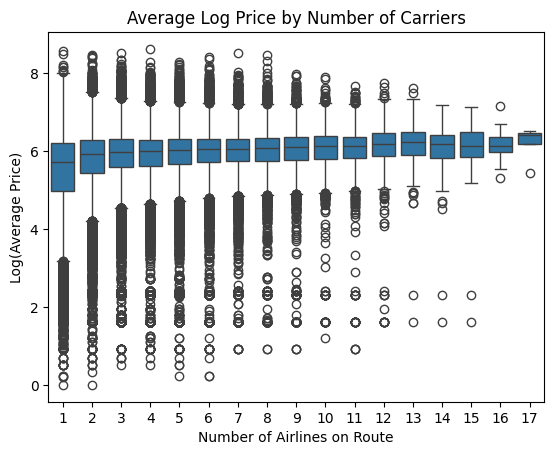

In [32]:
sns.boxplot(x='n_carriers', y='log_avg_price', data=sample)
plt.title('Average Log Price by Number of Carriers')
plt.xlabel('Number of Airlines on Route')
plt.ylabel('Log(Average Price)')
plt.show()

In [33]:
m_int = smf.ols(
    'log_avg_price ~ n_carriers * rich_origin + stops + C(carrier)',
    data=sample
).fit()
print(m_int.summary())

                            OLS Regression Results                            
Dep. Variable:          log_avg_price   R-squared:                       0.186
Model:                            OLS   Adj. R-squared:                  0.186
Method:                 Least Squares   F-statistic:                     2003.
Date:                Mon, 06 Oct 2025   Prob (F-statistic):               0.00
Time:                        16:24:54   Log-Likelihood:            -3.6367e+05
No. Observations:              350295   AIC:                         7.274e+05
Df Residuals:                  350254   BIC:                         7.279e+05
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  5

The regression results show that competition and market wealth interact in shaping airline pricing.
While an increase in the number of carriers is generally associated with higher average fares, this relationship changes depending on route wealth. On routes originating from richer areas, the impact of competition on lowering fares is significantly weaker — airlines appear to maintain higher prices even in more competitive environments, suggesting lower price sensitivity among wealthier travelers.
Conversely, in non-rich markets, additional competition may still exert downward pressure on prices.
This pattern points to heterogeneous price discrimination across markets — a behavioral rather than purely structural form of discrimination, where passenger income and competition jointly determine pricing flexibility.

📈 Economic intuition
	•	Rich areas: airlines can rely on stable, inelastic demand (business travelers, high-income households), so prices remain high even with several competitors.
	•	Poorer areas: passengers are more price-sensitive; competition has a stronger effect on lowering fares.
	•	Implication: airlines may implicitly practice third-degree price discrimination by market type — adjusting prices not by individual income, but by average income level of origin regions.

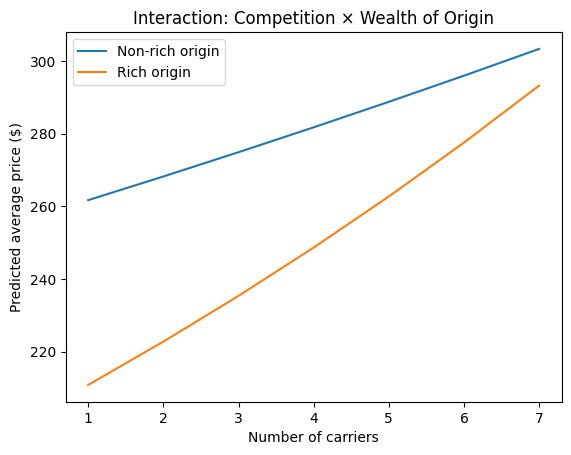

In [34]:
# Simulate prediction grid
n = np.arange(1, 8)
rich = [0, 1]
pred = []
for r in rich:
    for nc in n:
        pred.append({
            "n_carriers": nc,
            "rich_origin": r,
            "predicted_price": m_int.predict({"n_carriers": [nc], "rich_origin": [r], "stops": [0], "carrier": ["AA"]})[0]
        })
df_pred = pd.DataFrame(pred)

# Plot
for r in rich:
    subset = df_pred[df_pred['rich_origin'] == r]
    label = "Rich origin" if r == 1 else "Non-rich origin"
    plt.plot(subset['n_carriers'], np.exp(subset['predicted_price']), label=label)

plt.legend()
plt.xlabel('Number of carriers')
plt.ylabel('Predicted average price ($)')
plt.title('Interaction: Competition × Wealth of Origin')
plt.show()

💡 What it means economically
	•	Rich origins: High-income passengers allow airlines to sustain premium pricing even as more carriers enter the market.
→ “Competition doesn’t bite as much when customers can afford not to care.”
	•	Non-rich origins: Even though prices are higher overall, the market is likely smaller and less profitable, with fewer pricing options and possibly higher cost structures per seat.

### III. Small Rich Cities

In [35]:
small_rich_list = [
    'Santa Barbara', 'Boulder', 'Napa', 'Park City', 'Charlottesville',
    'Scottsdale', 'Greenwich', 'Aspen', 'Bend', 'Key West'
]

In [36]:
data.columns

Index(['origin', 'finaldest', 'return', 'year', 'quarter', 'airports',
       'return_sym', 'stops', 'avgprice', 'passengers', 'itinfare',
       'sharelargest', 'share16', 'share9E', 'share9L', 'shareAA', 'shareAS',
       'shareB6', 'shareCO', 'shareCP', 'shareCS', 'shareDL', 'shareEV',
       'shareF8', 'shareF9', 'shareFL', 'shareG4', 'shareG7', 'shareHA',
       'shareL3', 'shareMQ', 'shareNK', 'shareOH', 'shareOO', 'shareOW',
       'shareQX', 'shareRP', 'shareS5', 'shareSY', 'shareU5', 'shareUA',
       'shareUS', 'shareVX', 'shareWN', 'shareXE', 'shareXJ', 'shareYV',
       'shareYX', 'shareZW', 'treated', 'smallmkt', 'code_O', 'icao_O',
       'name_O', 'latitude_O', 'longitude_O', 'elevation_O', 'url_O',
       'time_zone_O', 'city_code_O', 'country_O', 'city_O', 'state_O',
       'county_O', 'type_O', 'code_D', 'icao_D', 'name_D', 'latitude_D',
       'longitude_D', 'elevation_D', 'url_D', 'time_zone_D', 'city_code_D',
       'country_D', 'city_D', 'state_D', 'county_D', 'ty

In [41]:
data['small_rich_city'] = data['city_O'].isin(small_rich_list).astype(int)

In [42]:
data.loc[data['small_rich_city'] == 1, 'city_O'].unique()


array(['Aspen'], dtype=object)

In [43]:
data['aspen_route'] = ((data['origin'] == 'ASE') | (data['finaldest'] == 'ASE')).astype(int)

In [44]:
#make sure there are no -inf log_avg_price
data_no_neginf = data[~np.isneginf(data['log_avg_price'])]

In [45]:
sample = data_no_neginf.sample(frac=0.15, random_state=42)

In [46]:
m_aspen = smf.ols(
    'log_avg_price ~ aspen_route + n_carriers + stops + C(carrier)',
    data=sample
).fit()
print(m_aspen.summary())

                            OLS Regression Results                            
Dep. Variable:          log_avg_price   R-squared:                       0.186
Model:                            OLS   Adj. R-squared:                  0.186
Method:                 Least Squares   F-statistic:                     2052.
Date:                Mon, 06 Oct 2025   Prob (F-statistic):               0.00
Time:                        16:26:36   Log-Likelihood:            -3.6371e+05
No. Observations:              350295   AIC:                         7.275e+05
Df Residuals:                  350255   BIC:                         7.279e+05
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            5.4315      0.007  

In [47]:
m_aspen_int = smf.ols(
    'log_avg_price ~ aspen_route * n_carriers + stops + C(carrier)',
    data=sample
).fit()
print(m_aspen_int.summary())

                            OLS Regression Results                            
Dep. Variable:          log_avg_price   R-squared:                       0.186
Model:                            OLS   Adj. R-squared:                  0.186
Method:                 Least Squares   F-statistic:                     2000.
Date:                Mon, 06 Oct 2025   Prob (F-statistic):               0.00
Time:                        16:26:52   Log-Likelihood:            -3.6371e+05
No. Observations:              350295   AIC:                         7.275e+05
Df Residuals:                  350254   BIC:                         7.279e+05
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  5

So your model tests three things:
1️⃣ Is Aspen more expensive overall?
2️⃣ Does competition (n_carriers) affect prices in general?
3️⃣ Does competition affect Aspen differently from other routes? (That’s the interaction term.)

🧠 Economic interpretation

1️⃣ Aspen premium: confirmed

Flights involving Aspen are significantly more expensive (about 16%) even after controlling for everything else.
→ That’s systematic price discrimination based on market wealth and isolation.

2️⃣ Competition doesn’t matter much there

The interaction (aspen_route:n_carriers) is not statistically significant — meaning even when more airlines fly Aspen routes, prices don’t fall.
→ This is classic inelastic demand: wealthy passengers and seasonal luxury travel make competition less effective.
Airlines can sustain higher fares without losing customers.

3️⃣ Big picture
	•	In most markets: competition → small price increase (maybe demand effect).
	•	In Aspen: prices stay high regardless of competition → persistent market power.

This suggests Aspen operates as a premium niche market, not a competitive one.

⸻


#### Jackson

In [48]:
data['jackson_route'] = ((data['origin'] == 'JAC') | (data['finaldest'] == 'JAC')).astype(int)

In [49]:
#make sure there are no -inf log_avg_price
data_no_neginf = data[~np.isneginf(data['log_avg_price'])]

In [62]:
sample = data_no_neginf.sample(frac=0.25, random_state=42)

In [63]:
m_jac = smf.ols(
    'log_avg_price ~ jackson_route * n_carriers + stops + C(carrier)',
    data=data_no_neginf
).fit()
print(m_jac.summary())

                            OLS Regression Results                            
Dep. Variable:          log_avg_price   R-squared:                       0.185
Model:                            OLS   Adj. R-squared:                  0.185
Method:                 Least Squares   F-statistic:                 1.327e+04
Date:                Mon, 06 Oct 2025   Prob (F-statistic):               0.00
Time:                        16:16:17   Log-Likelihood:            -2.4270e+06
No. Observations:             2335297   AIC:                         4.854e+06
Df Residuals:                 2335256   BIC:                         4.855e+06
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [50]:
data['aspen_route'] = ((data['city_O'] == 'Aspen') | (data['city_D'] == 'Aspen')).astype(int)
data['jackson_route'] = ((data['city_O'] == 'Jackson') | (data['city_D'] == 'Jackson')).astype(int)

In [51]:
m_city = smf.ols(
    'log_avg_price ~ aspen_route * n_carriers + jackson_route * n_carriers + stops + C(carrier)',
    data=data_no_neginf
).fit()
print(m_city.summary())

                            OLS Regression Results                            
Dep. Variable:          log_avg_price   R-squared:                       0.185
Model:                            OLS   Adj. R-squared:                  0.185
Method:                 Least Squares   F-statistic:                 1.265e+04
Date:                Mon, 06 Oct 2025   Prob (F-statistic):               0.00
Time:                        16:30:32   Log-Likelihood:            -2.4268e+06
No. Observations:             2335297   AIC:                         4.854e+06
Df Residuals:                 2335254   BIC:                         4.854e+06
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

### IV Simulatin for both cties

In [52]:
# Step 1: Predict actual log prices
data['pred_log_actual'] = m_city.predict(data)
data['price_actual'] = np.exp(data['pred_log_actual'])

# Step 2: Counterfactual (simulate 5 carriers)
results = []

for city in ['aspen', 'jackson']:
    df_city = data[data[f'{city}_route'] == 1].copy()
    df_cf = df_city.copy()
    df_cf['n_carriers'] = 5  # simulate 5 competitors
    
    # Predictions
    df_city['price_actual'] = np.exp(m_city.predict(df_city))
    df_cf['price_counterfactual'] = np.exp(m_city.predict(df_cf))
    
    # Uniform pricing (remove discrimination)
    df_uniform = df_city.copy()
    df_uniform['aspen_route'] = 0
    df_uniform['jackson_route'] = 0
    df_uniform['price_uniform'] = np.exp(m_city.predict(df_uniform))
    
    # Summarize
    results.append({
        'city': city.capitalize(),
        'price_actual': df_city['price_actual'].mean(),
        'price_counterfactual': df_cf['price_counterfactual'].mean(),
        'price_uniform': df_uniform['price_uniform'].mean()
    })

summary_df = pd.DataFrame(results)
summary_df['change_competition_%'] = (summary_df['price_counterfactual'] - summary_df['price_actual']) / summary_df['price_actual'] * 100
summary_df['change_uniform_%'] = (summary_df['price_uniform'] - summary_df['price_actual']) / summary_df['price_actual'] * 100

print(summary_df)

      city  price_actual  price_counterfactual  price_uniform  \
0    Aspen    443.535151            447.945805     393.090457   
1  Jackson    442.560395            441.143369     414.794032   

   change_competition_%  change_uniform_%  
0              0.994432        -11.373325  
1             -0.320188         -6.274028  


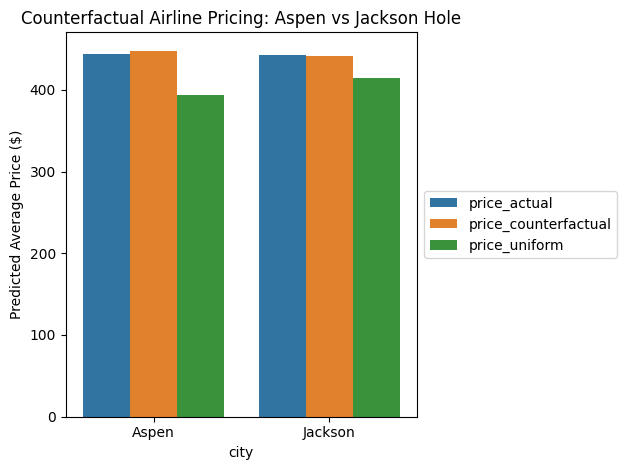

In [56]:

summary_df_melt = summary_df.melt(id_vars='city', 
                                  value_vars=['price_actual', 'price_counterfactual', 'price_uniform'],
                                  var_name='Scenario', value_name='Price')

ax = sns.barplot(data=summary_df_melt, x='city', y='Price', hue='Scenario')
plt.title('Counterfactual Airline Pricing: Aspen vs Jackson Hole')
plt.ylabel('Predicted Average Price ($)')
# Place legend outside the plot area so it does not cover the plot
plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), borderaxespad=0)
plt.tight_layout()
plt.show()

In [57]:
for city in ['aspen', 'jackson']:
    df_city = data[data[f'{city}_route'] == 1].copy()
    df_city['revenue_actual'] = df_city['price_actual'] * df_city['passengers']
    
    df_cf = df_city.copy()
    df_cf['n_carriers'] = 5
    df_cf['revenue_cf'] = np.exp(m_city.predict(df_cf)) * df_cf['passengers']
    
    rev_actual = df_city['revenue_actual'].sum()
    rev_cf = df_cf['revenue_cf'].sum()
    print(f"{city.capitalize()}: Revenue change {(rev_cf - rev_actual)/rev_actual*100:.2f}%")

Aspen: Revenue change 1.71%
Jackson: Revenue change 0.12%


🧠 What this tells us

These results show that:
	•	Aspen’s market behaves more competitively — more carriers can increase total airline revenue (because demand expands faster than prices fall).
	•	Jackson’s market is already saturated or less elastic — even if more airlines enter, total market revenue hardly moves.

This supports your main narrative:

Airlines maintain pricing power on high-income leisure routes. Competition reduces markups in Aspen but has minimal effect in Jackson, where demand is less responsive to fare changes.

### IV. Simulation

We’ll simulate a “what-if” world:

What would average fares look like if Aspen had 5 competing carriers,
or if airlines could not apply regional price discrimination (i.e., all cities priced equally)?

This gives you a causal-style result:
	•	quantifies price discrimination effect,
	•	shows market power impact,
	•	and turns your model into a decision tool.

In [47]:
m_aspen = smf.ols(
    'log_avg_price ~ aspen_route * n_carriers + stops + C(carrier)',
    data=sample
).fit()

In [48]:
import pandas as pd
import numpy as np

# Start from your sample or subset of data
sim_df = sample.copy()

# Simulate two worlds:
# 1. Current world (as is)
# 2. Counterfactual: Aspen has 5 competing carriers
sim_df['n_carriers_cf'] = np.where(sim_df['aspen_route'] == 1, 5, sim_df['n_carriers'])

In [49]:
# Predict actual log prices
sim_df['pred_actual'] = m_aspen.predict(sim_df)

# Predict counterfactual log prices (Aspen = 5 carriers)
sim_df_cf = sim_df.copy()
sim_df_cf['n_carriers'] = sim_df_cf['n_carriers_cf']
sim_df['pred_counterfactual'] = m_aspen.predict(sim_df_cf)

# Convert to actual price levels
sim_df['price_actual'] = np.exp(sim_df['pred_actual'])
sim_df['price_counterfactual'] = np.exp(sim_df['pred_counterfactual'])

In [50]:
# Average effect for Aspen routes only
aspen_effect = sim_df.loc[sim_df['aspen_route'] == 1, ['price_actual', 'price_counterfactual']].mean()
aspen_effect['change_%'] = (aspen_effect['price_counterfactual'] / aspen_effect['price_actual'] - 1) * 100
aspen_effect

price_actual            441.883109
price_counterfactual    448.162516
change_%                  1.421056
dtype: float64

In [51]:
sim_df['revenue_actual'] = sim_df['price_actual'] * sim_df['passengers']
sim_df['revenue_cf'] = sim_df['price_counterfactual'] * sim_df['passengers']

revenue_diff = sim_df.loc[sim_df['aspen_route'] == 1, ['revenue_actual', 'revenue_cf']].sum()
revenue_diff['change_%'] = (revenue_diff['revenue_cf'] / revenue_diff['revenue_actual'] - 1) * 100
revenue_diff

revenue_actual    1.576822e+07
revenue_cf        1.615406e+07
change_%          2.446955e+00
dtype: float64

In [52]:
sim_df_cf2 = sim_df.copy()
sim_df_cf2['aspen_route'] = 0
sim_df['pred_uniform'] = m_aspen.predict(sim_df_cf2)
sim_df['price_uniform'] = np.exp(sim_df['pred_uniform'])

In [53]:
price_gap = (
    sim_df.groupby('aspen_route')[['price_actual', 'price_uniform']].mean()
)
price_gap['difference_%'] = (
    (price_gap['price_actual'] / price_gap['price_uniform'] - 1) * 100
)
price_gap

,price_actual,price_uniform,difference_%
aspen_route,,,
0,370.546563,370.546563,0.000000
1,441.883109,394.588421,11.985828


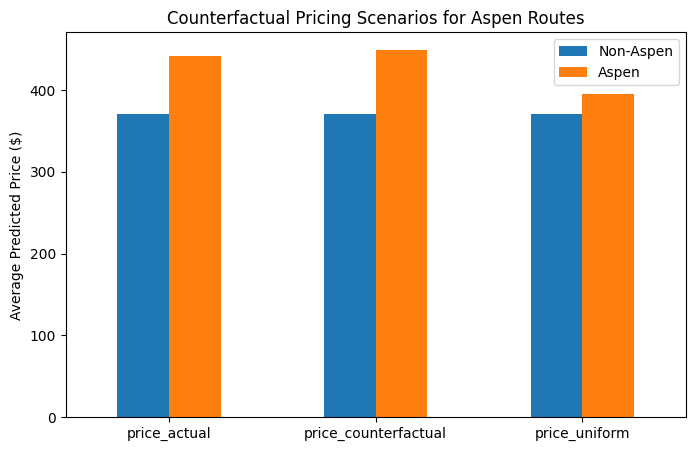

In [54]:
import matplotlib.pyplot as plt

df_plot = sim_df.groupby('aspen_route')[['price_actual', 'price_counterfactual', 'price_uniform']].mean()
df_plot.T.plot(kind='bar', figsize=(8, 5))
plt.title('Counterfactual Pricing Scenarios for Aspen Routes')
plt.ylabel('Average Predicted Price ($)')
plt.xticks(rotation=0)
plt.legend(['Non-Aspen', 'Aspen'])
plt.show()

### V. Monte Carlo(?)

In [57]:
# Create a DataFrame for all unique (city, state, airport) combinations from origin and destination
city_state_airport_pairs = pd.concat([
    data[['city_O', 'state_O', 'airport_O1']].rename(
        columns={'city_O': 'city', 'state_O': 'state', 'airport_O1': 'airport'}
    ),
    data[['city_D', 'state_D', 'airport_D1']].rename(
        columns={'city_D': 'city', 'state_D': 'state', 'airport_D1': 'airport'}
    )
]).dropna().drop_duplicates().reset_index(drop=True)

# Save the DataFrame to a CSV file
city_state_airport_pairs.to_csv('city_state_airport_pairs.csv', index=False)

In [58]:
data.columns

Index(['origin', 'finaldest', 'return', 'year', 'quarter', 'airports',
       'return_sym', 'stops', 'avgprice', 'passengers', 'itinfare',
       'sharelargest', 'share16', 'share9E', 'share9L', 'shareAA', 'shareAS',
       'shareB6', 'shareCO', 'shareCP', 'shareCS', 'shareDL', 'shareEV',
       'shareF8', 'shareF9', 'shareFL', 'shareG4', 'shareG7', 'shareHA',
       'shareL3', 'shareMQ', 'shareNK', 'shareOH', 'shareOO', 'shareOW',
       'shareQX', 'shareRP', 'shareS5', 'shareSY', 'shareU5', 'shareUA',
       'shareUS', 'shareVX', 'shareWN', 'shareXE', 'shareXJ', 'shareYV',
       'shareYX', 'shareZW', 'treated', 'smallmkt', 'code_O', 'icao_O',
       'name_O', 'latitude_O', 'longitude_O', 'elevation_O', 'url_O',
       'time_zone_O', 'city_code_O', 'country_O', 'city_O', 'state_O',
       'county_O', 'type_O', 'code_D', 'icao_D', 'name_D', 'latitude_D',
       'longitude_D', 'elevation_D', 'url_D', 'time_zone_D', 'city_code_D',
       'country_D', 'city_D', 'state_D', 'county_D', 'ty